# CMSC 35440 Machine Learning in Biology and Medicine
## Homework 3: Domain Adaptation of LLMs
**Released**: Feb 13, 2025

**Due**: Feb 23, 2025 at 11:59 PM Chicago Time on Gradescope

**In the third homework, you'll observe the relative importance of domain adaptation for LLMs in a zero-shot setting.**

As we covered in lecture, the core of the transformer model architecture is a quadratic attention mechanism where the relative importance of each token to every other token in a sequence is weighted using a learned attention score. This learned attention depends on the data the model was trained on.

Consider the sentence "the cell appeared small and round". A general domain model may associate "cell" with a prison cell; in such a context, "small" may well be more important than "round". However, a model trained over the biomedical domain, and specifically in digital pathology would be far more likely to associate "cell" with the biological meaning of the word. In context, if all cells are described as "small", the varying shapes, such as "round", may end up being more important. These are of course contrived examples, but it highlights how the context and domain of the model may impact the generated embedding.

To that end, you'll compare embeddings derived from 2 transformer encoder-only BERT models. The difference is that the first BERT model was trained on the general domain (bert-base) while the second was trained on the biomedical domain (PubMedBERT). The paper for PubMedBERT is well worth the read: https://arxiv.org/pdf/2007.15779.

The objective of the homework then is to see if domain-adapted embeddings of the same text yield better separability results for the different cancers of the TCGA without any additional model training (a zero-shot setting).

The starter notebook for this homework can be downloaded from GitHub:

https://github.com/StevenSong/CMSC-35440-Source/blob/main/hw3/CMSC_35440_HW3_Student_Version.ipynb


## Instructions

1. Download the starter notebook. Having access to a GPU backed notebook instance will greatly accelerate the runtime for this homework.
    * On Colab, you can use a T4 16GB VRAM GPU for free by changing the runtime type. This article has some screenshots on how to find that menu, steps 4-6: https://www.geeksforgeeks.org/how-to-use-gpu-in-google-colab/
2. Download and load the data from https://raw.githubusercontent.com/StevenSong/CMSC-35440-Source/refs/heads/main/hw3/TCGA_Reports.csv.
    * It's a CSV with 4 columns. For this homework, we'll embed the `text` and visualize the embeddings using the `project_id`.
3. Use huggingface `transformers` to load 2 BERT models and their corresponding tokenizers:
    * For those unfamiliar with huggingface, the `AutoModel.from_pretrained(model_name)` and `AutoTokenizer.from_pretrained(model_name)` utilities are the easiest way to load these models.
    * General domain BERT: [`google-bert/bert-base-uncased`](https://huggingface.co/google-bert/bert-base-uncased)
    * Biomedical domain BERT (formerly PubMedBERT): [`microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext`](https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext)
    * Make sure to set both models into eval mode by calling `.eval()` on the model instance.
    * Also move both models to the GPU by calling `.to("cuda")` on the model instance. Both models will fit simultaneously on the Colab free-tier GPU with plenty of room to spare.
    * Some code example:
    ```python
    model = AutoModel.from_pretrained(model_name)
    model.eval().to("cuda")
    ```
4. Tokenize the text from the data. Be sure to use the tokenizer for the specific model. Models are trained over a specific vocabulary mapping!
    * This is most efficient when using batches of text. Batch size of 64 worked well for the reference implementation.
    * The text is often far too long to fit in the model's context length, so we do truncation/padding to the model context length (both 512 in this case).
    * Also move the batch to the GPU by similarly calling `.to("cuda")` on the tensors returned by the tokenizer.
    * Here's some code to help:
    ```python
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    [...]
    text_batch = ["foo", "bar", ...] # list of str
    batch_in = tokenizer(text_batch, truncation=True, padding="max_length",
                           max_length=512, return_tensors="pt")
    batch_in = {k: v.to("cuda") for k, v in batch_in.items()}
    ```
5. Compute embeddings using both the general domain and domain adapted models.
    * Again batching is the most efficient way to do this.
    * Make sure to use the `torch.inference_mode()` context manager so as not to compute gradients (takes extra memory and we won't use them).
    * Embeddings are computed by passing the output of the tokenizer as keyword arguments to the model's call method.
    * It's common practice when training BERT models to prepend a `[CLS]` token to the start of each text input. This token is often referred to as the classification token as it is the contextualized embedding of this token that is used in downstream tasks. Furthermore, this token's embedding is often passed through another linear layer and activation function by a "pooling" module. This final output is returned in huggingface BERT models as `output.pooler_output`.
    * Make sure to move computed embeddings off the GPU by calling `.cpu()` on the returned tensor.
    * Some code:
    ```python
    with torch.inference_mode():
        batch_out = model(**batch_in).pooler_output.cpu()
    ```
6. Visualize your embeddings in 2 dimensions, coloring by the TCGA project column.
    * Please use a discrete colormap rather a continuous one. There are 32 unique TCGA projects so it's okay to have duplicate colors. `tab20` is a reasonable choice: https://matplotlib.org/stable/gallery/color/colormap_reference.html.
    * The choice of PCA, UMAP, or TSNE is up to you.
7. Discuss the following questions:
    * Does biomedical domain adaptation help produce more meaningful embeddings?
    * How does our truncation strategy impact the content of the embedding?
    * When might biomedical domain adaptation **NOT** be necessary?
    * Your writeup should be 0.5 to 1 page, excluding figures. 12pt font, single space, 1 inch margins, letter size paper. Please submit either a PDF or a Word document.
8. Submit your homework on Gradescope. Make sure to include:
    * Your writeup containing a figure with your embedding visualization.
    * Your notebook and any extra code you need to make it run. Do not submit data; the only exception to this is if you have made significant modifications to the source data.

## Code

In [1]:
!wget https://raw.githubusercontent.com/StevenSong/CMSC-35440-Source/refs/heads/main/hw3/TCGA_Reports.csv

--2025-02-23 19:31:31--  https://raw.githubusercontent.com/StevenSong/CMSC-35440-Source/refs/heads/main/hw3/TCGA_Reports.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35682272 (34M) [text/plain]
Saving to: ‘TCGA_Reports.csv’

TCGA_Reports.csv    100%[===================>]  34.03M   124MB/s    in 0.3s    

2025-02-23 19:31:32 (124 MB/s) - ‘TCGA_Reports.csv’ saved [35682272/35682272]



In [52]:
import pandas as pd
import numpy as np
import re
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print(torch.cuda.is_available())

True


In [17]:
df = pd.read_csv("TCGA_Reports.csv")
df.head()

,patient_filename,text,case_id,project_id
0,TCGA-BP-5195.25c0b433-5557-4165-922e-2c1eac9c26f0,Date of Recelpt: Clinical Diagnosis & History:...,TCGA-BP-5195,TCGA-KIRC
1,TCGA-D7-8573.b7306a47-697d-4ed3-bbe1-81d49674a8f8,"Material: 1) Material: stomach, Method of coll...",TCGA-D7-8573,TCGA-STAD
2,TCGA-EI-7004.13591eed-30e5-47a3-91be-7a370663d2d4,page 1 / 1. copy No. 3. Examination: Histopath...,TCGA-EI-7004,TCGA-READ
3,TCGA-EB-A82B.23E186C6-739C-4EF1-8788-79AA89C6E87A,Patient ID: Gross Description: A mass is locat...,TCGA-EB-A82B,TCGA-SKCM
4,TCGA-A6-3808.e1505f65-72ef-438d-a5e1-93ed8bf6635d,SPECIMEN. Right colon. CLINICAL NOTES. PRE-OP ...,TCGA-A6-3808,TCGA-COAD


In [22]:
def clean_word(text):
    text = text.lower()
    text = re.sub('\n+', " ", text)  # change \n to " "
    text = re.sub('\[[0-9]*\]', "", text)  # Delete [1]
    text = re.sub(' +', " ", text)  # Change several " " to one " "
    text = re.sub('\(end\)', "", text)  # Delete (end)

    text = re.sub('@[^\s]+', '', text)
    text = re.sub('#([^\s]+)', '', text)
    text = re.sub('[:;>?<=*+()&,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]', ' ', text)  # Special char
    text = re.sub('[\d]', '', text)  # decimal digit
    text = text.replace(".", '')  # Delete .
    text = text.replace("`", '')  # Delete `
    text = text.replace("'s", '')  # Delete 's
    text = text.replace("'", '')  # Delete '
    text = text.replace("/", ' ')
    text = text.replace("\"", ' ')
    text = text.replace("\\", '')
    text = re.sub(r"\b[a-z]\b", "", text)
    text = re.sub('\s+', ' ', text)  # Delete extra spaces

    text = text.strip()  # delete spaces at beginning and ending

    return text

In [23]:
df['cleaned_text'] = df['text'].map(clean_word)
df.head()

,patient_filename,text,case_id,project_id,cleaned_text
0,TCGA-BP-5195.25c0b433-5557-4165-922e-2c1eac9c26f0,Date of Recelpt: Clinical Diagnosis & History:...,TCGA-BP-5195,TCGA-KIRC,date of recelpt clinical diagnosis history inc...
1,TCGA-D7-8573.b7306a47-697d-4ed3-bbe1-81d49674a8f8,"Material: 1) Material: stomach, Method of coll...",TCGA-D7-8573,TCGA-STAD,material material stomach method of collection...
2,TCGA-EI-7004.13591eed-30e5-47a3-91be-7a370663d2d4,page 1 / 1. copy No. 3. Examination: Histopath...,TCGA-EI-7004,TCGA-READ,page copy no examination histopathological exa...
3,TCGA-EB-A82B.23E186C6-739C-4EF1-8788-79AA89C6E87A,Patient ID: Gross Description: A mass is locat...,TCGA-EB-A82B,TCGA-SKCM,patient id gross description mass is located i...
4,TCGA-A6-3808.e1505f65-72ef-438d-a5e1-93ed8bf6635d,SPECIMEN. Right colon. CLINICAL NOTES. PRE-OP ...,TCGA-A6-3808,TCGA-COAD,specimen right colon clinical notes pre op dia...


In [50]:
def compute_embeddings(model_name, df, batch_size=64):
  # Load model and tokenizer
  model = AutoModel.from_pretrained(model_name)
  model.eval().to("cuda")
  print(next(model.parameters()).device)

  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # Tokenization
  ls_batches = []
  for i in range(0, len(df), batch_size):
      batch_df = df.iloc[i:i+batch_size]
      text_batch = batch_df['cleaned_text'].tolist()
      batch_in = tokenizer(text_batch, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
      batch_in = {k: v.to("cuda") for k, v in batch_in.items()}
      ls_batches.append(batch_in)

  # Compute the Embeddings
  ls_embeddings = []
  for j, batch in enumerate(tqdm(ls_batches, desc="Processing Batches")):
      with torch.inference_mode():
          batch_out = model(**batch).pooler_output.cpu()
      ls_embeddings.append(batch_out)
  flattened_embeddings = torch.cat(ls_embeddings, dim=0) # merge samples from different batches into one batch
  df['embeddings'] = [emb.numpy() for emb in flattened_embeddings]

  return df

In [26]:
def normalize_embeddings(embeddings_list):
    normalized_list = []
    for emb in embeddings_list:
        emb_np = np.array(emb)  # Convert to NumPy array
        norm = np.linalg.norm(emb_np)
        if norm == 0:
            normalized_list.append(emb_np)  # Avoid division by zero
        else:
            normalized_list.append(emb_np / norm)  # Normalize
    return normalized_list

In [57]:
def visualize_embeddings(df, model_name):
    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_embeddings_pca = pca.fit_transform(np.stack(df['normalized_embeddings'].values))

    # Add PCA components to metadata
    df['PCA1'] = reduced_embeddings_pca[:, 0]
    df['PCA2'] = reduced_embeddings_pca[:, 1]

    print('Finish Dimension Reduction!')

    plt.figure(figsize=(10, 8))
    unique_projects = list(np.unique(df['project_id']))
    colors = plt.get_cmap("tab20", len(unique_projects))
    project_to_color = {proj: colors(i % 20) for i, proj in enumerate(unique_projects)}

    ax = sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='project_id',
                         palette=project_to_color, alpha=0.6, legend=True)

    # legend
    legend = ax.legend(title="Project ID", bbox_to_anchor=(0.5, -0.15), loc="upper center",
                       fontsize="small", frameon=True, ncol=8)

    plt.title(f'{model_name} Embeddings Visualization')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

cuda:0


Processing Batches: 100%|██████████| 149/149 [04:53<00:00,  1.97s/it]


Finish Dimension Reduction!


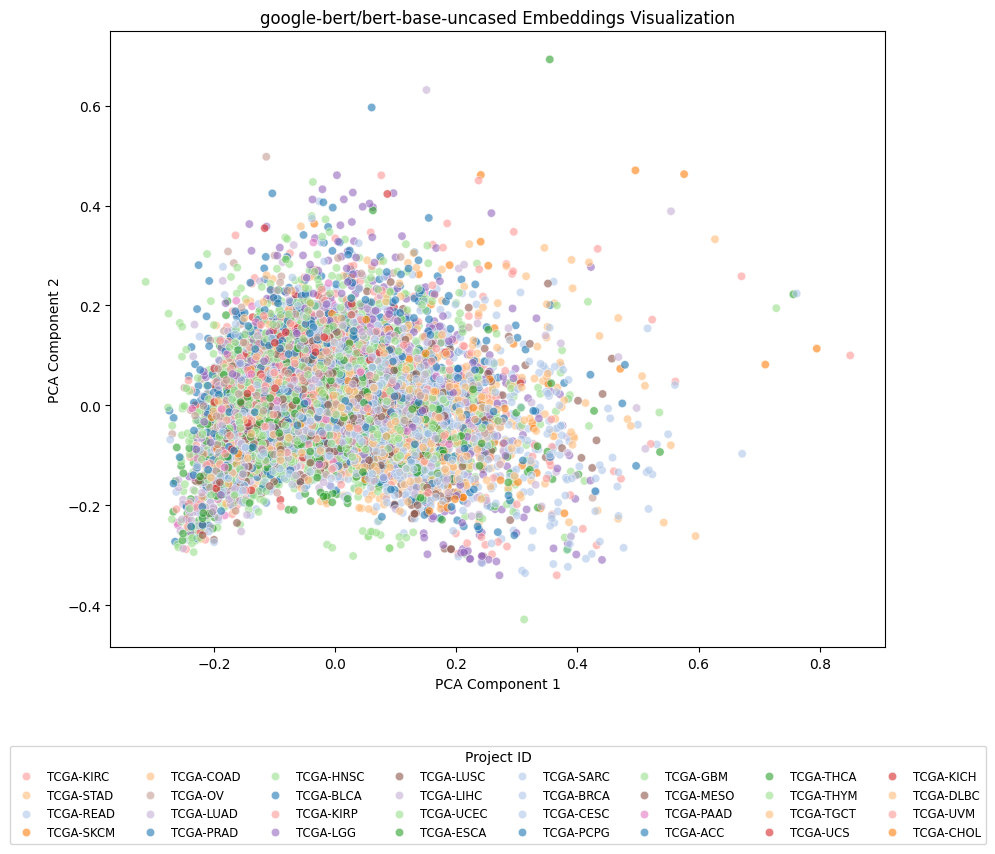

cuda:0


Processing Batches: 100%|██████████| 149/149 [04:16<00:00,  1.72s/it]


Finish Dimension Reduction!


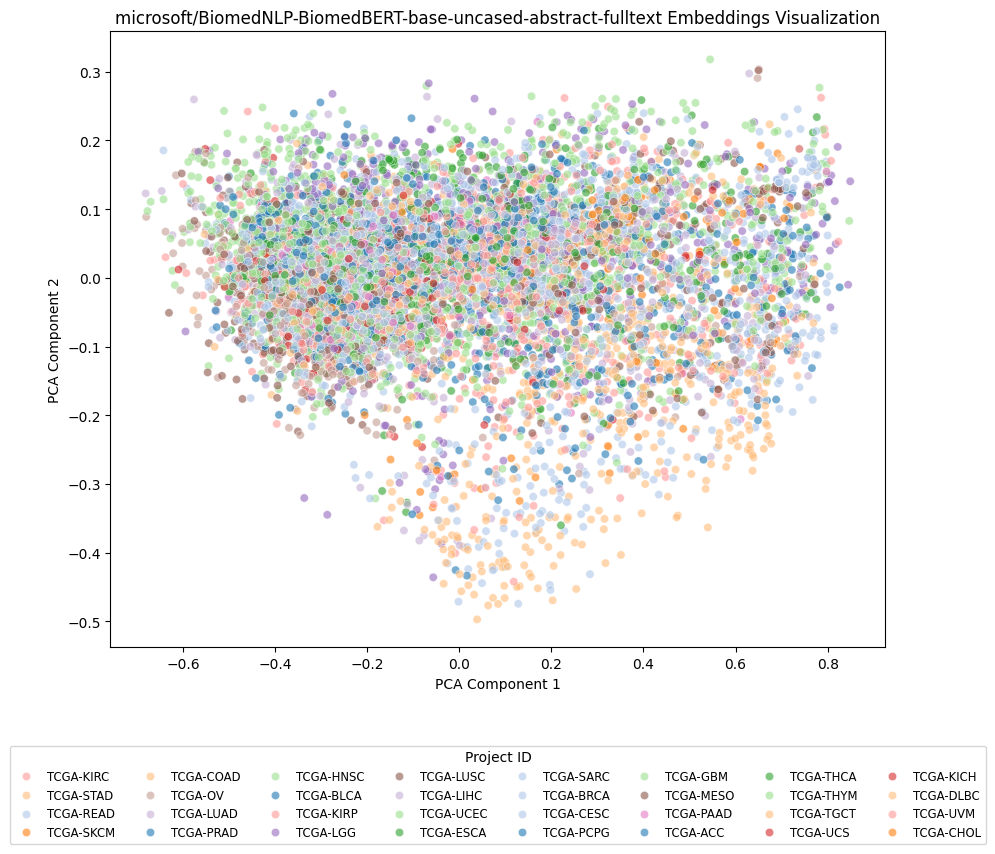

In [58]:
ls_models = ['google-bert/bert-base-uncased', 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext']

for model_name in ls_models:
  df = compute_embeddings(model_name, df)
  df['normalized_embeddings'] = normalize_embeddings(df['embeddings'].values)
  visualize_embeddings(df, model_name)